**Name:** \_\_\_\_\_

**EID:** \_\_\_\_\_

# CS4487 - Tutorial 5b: Predicting Popularity of Online News

In this tutorial you will train some kernel regression methods to predict the number of "shares" of a news article on Mashable.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
import csv
import string
random.seed(100)

## 1. Loading Data and Pre-processing
Next we need to load the data.  Download `OnlineNewsPopularity.zip`, and **unzip** it in the same directory as this ipynb file.  Then run the following cell to load the data.

In [2]:
filename = 'OnlineNewsPopularity/OnlineNewsPopularity.csv'

# read the data
allfeatnames = []
textdata      = []
with open(filename, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if len(allfeatnames)==0:
            allfeatnames = row
        else:
            textdata.append(row)

# put the data into a np array
dataX = empty((len(textdata), len(allfeatnames)-3))
dataY = empty(len(textdata))
for i,row in enumerate(textdata):
    # extract features (remove the first 2 features and the last feature)
    dataX[i,:] = array([float(x) for x in row[2:-1]])
    # extract target (last entry)
    dataY[i] = float(row[-1])
    
# extract feature names
featnames = [x.strip() for x in allfeatnames[2:-1]]

# extract a subset of data
dataX = dataX[::6]
dataY = dataY[::6]

print(dataX.shape)
print(dataY.shape)

(6608, 58)
(6608,)


There are 58 features for each article.  Here are the feature names, and an example entry.  The actual description of the features can be found in the `OnlineNewsPopularity-features.txt` file.

In [3]:
print(featnames)

print("--- example article features---")
print(dataX[0])
print("--- example article target (# of shares)")
print(dataY[0])

['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarit

Now separate the data into training and testing sets.

In [4]:
# randomly split data into 50% train and 50% test set
trainX, testX, trainYo, testYo = \
  model_selection.train_test_split(dataX, dataY, 
  train_size=0.50, test_size=0.50, random_state=4487)

print(trainX.shape)
print(testX.shape)

(3304, 58)
(3304, 58)


Finally, we normalize the input features.

In [5]:
# normalize feature values
# this makes comparing weights more meaningful
scaler = preprocessing.StandardScaler()  
trainXn = scaler.fit_transform(trainX)  
testXn  = scaler.transform(testX)    

Because the target value (number of shares) has a large dynamic range, we will transform the target values through the log function.

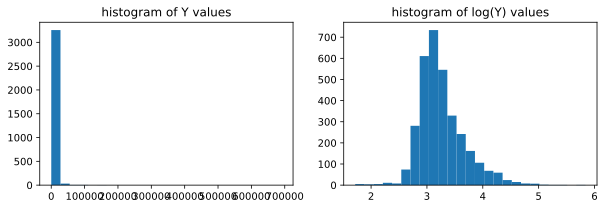

In [6]:
# map targets to log-space
trainY = log10(trainYo)
testY  = log10(testYo)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.hist(trainYo, 25);
plt.title('histogram of Y values')
plt.subplot(1,2,2)
plt.hist(trainY, 25);
plt.title("histogram of log(Y) values");

## 2. Kernel Methods and Supprot Vector Regression 
Next, let us try some non-linear regression model such as[ kernel ridge regression](https://scikit-learn.org/stable/modules/kernel_ridge.html), [random forest regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)(Optional), [support vector regression](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html). To improve the prediction accuracy in Tutorial 4, and using cross-validation on the training set to select the parameters.  

In [7]:
### INSERT YOUR CODE HERE
##Hint: 
## 1. Kernel Ridge Regression:  kernel_ridge.KernelRidge(kernel='rbf'/'poly')
## 2. Random Forest Regression: ensemble.RandomForestRegressor(random_state= , n_estimators= )
## 3. Support Vector Regression: svm.SVR(kernel='poly')
## 4. Avoid using large values of $C$ with SVR.

In [8]:
allexps = [
    {'name': 'krr-rbf',
     'clf': kernel_ridge.KernelRidge(kernel='rbf'),
     'params': {'alpha': logspace(-3,3,10), 'gamma': logspace(-6,3,10)}
    }, 
    {'name': 'krr-poly',
     'clf': kernel_ridge.KernelRidge(kernel='poly'),
     'params': {'alpha': logspace(-3,3,10), 'degree': [1,2,3,4,5]}
    }, 
    {'name': 'rf',
     'clf': ensemble.RandomForestRegressor(random_state=4487, n_estimators=100),
     'params': {'max_depth': array([1, 2, 3, 4, 5, 10, 15])}
    }, 
    {'name': 'svr-poly',
     'clf': svm.SVR(kernel='poly'),
     'params':  {'C': logspace(-3,0,5), 'degree': [1,2], 'epsilon': logspace(-2,2,5)}
    }, 
]

clfs = {}
trainAE = {}
testAE = {}
for i,ex in enumerate(allexps):
    myname = ex['name']
    print("=== " + myname + " ==================")
    clfs[myname] = model_selection.GridSearchCV(ex['clf'], ex['params'], 
                    scoring='neg_mean_squared_error', cv=5, verbose=True, n_jobs=-1)
    clfs[myname].fit(trainXn, trainY)

    print(clfs[myname].best_score_)
    print(clfs[myname].best_params_)

    trainAE[myname] = metrics.mean_absolute_error(trainY, clfs[myname].predict(trainXn))
    testAE[myname]  = metrics.mean_absolute_error(testY, clfs[myname].predict(testXn))

    print("train error:", trainAE[myname])
    print("test error :", testAE[myname])

=== krr-rbf ==================
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.1min finished


-0.15530121506823705
{'alpha': 0.001, 'gamma': 0.0001}
train error: 0.2717928728100252
test error : 0.2805575276768934
=== krr-poly ==================
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.8min finished
c:\users\hanwei_zhu\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


-0.15525715355312703
{'alpha': 10.0, 'degree': 2}
train error: 0.26883106068172585
test error : 0.27956156164035045
=== rf ==================
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.5min finished


-0.15601165215025242
{'max_depth': 10}
train error: 0.2006937262482335
test error : 0.2840389476667905
=== svr-poly ==================
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   37.0s finished


-0.16411340068182131
{'C': 0.03162277660168379, 'degree': 1, 'epsilon': 0.1}
train error: 0.2812463784219451
test error : 0.27492017267526386


In [17]:
# LASSO - poly features
polyfeats = preprocessing.PolynomialFeatures(degree=2)
trainXnf  = polyfeats.fit_transform(trainXn)
testXnf   = polyfeats.transform(testXn) 

myname = 'las-poly'
clfs[myname] = linear_model.LassoCV(max_iter=2000)
clfs[myname].fit(trainXnf, trainY)
trainAE[myname] = metrics.mean_absolute_error(trainY, clfs[myname].predict(trainXnf))
testAE[myname]  = metrics.mean_absolute_error(testY, clfs[myname].predict(testXnf))

print("train error:", trainAE[myname])
print("test error :", testAE[myname])

c:\users\hanwei_zhu\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
c:\users\hanwei_zhu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6762291031430436, tolerance: 0.03771280016805901
  tol, rng, random, positive)
c:\users\hanwei_zhu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2105285423632779, tolerance: 0.03771280016805901
  tol, rng, random, positive)
c:\users\hanwei_zhu\appdata\local\programs\python\python37\lib\site-packa

c:\users\hanwei_zhu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.59980216872455, tolerance: 0.03771280016805901
  tol, rng, random, positive)
c:\users\hanwei_zhu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.089604430768475, tolerance: 0.03771280016805901
  tol, rng, random, positive)
c:\users\hanwei_zhu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.494570281770862, tolerance: 0.03771280016805901
  tol, rng, random, positive)
c:\users\hanwei_zhu\appdata\local\program

c:\users\hanwei_zhu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.9702739928440565, tolerance: 0.03803699558073696
  tol, rng, random, positive)
c:\users\hanwei_zhu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.703140027440327, tolerance: 0.03803699558073696
  tol, rng, random, positive)
c:\users\hanwei_zhu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.194588906294968, tolerance: 0.03803699558073696
  tol, rng, random, positive)
c:\users\hanwei_zhu\appdata\local\programs

c:\users\hanwei_zhu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.957090093423801, tolerance: 0.03789388576386035
  tol, rng, random, positive)
c:\users\hanwei_zhu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4323306047310496, tolerance: 0.03789388576386035
  tol, rng, random, positive)


train error: 0.28645700047885225
test error : 0.2863086956691795


In [18]:
# sort coefficients from smallest to largest, then reverse it
inds = argsort(abs(clfs['las-poly'].coef_))[::-1]
print(len(polyfeats.powers_))
# print out
print("weight : feature description")
for i in inds:
    if abs(clfs['las-poly'].coef_[i])>1e-3:
        # get active features and powers
        pows = where(polyfeats.powers_[i])[0]
        fstr = ""
        for p in pows:
            fstr += featnames[p] + "(" + str(polyfeats.powers_[i][p]) + ") "
        print("{: .3f} : {}".format(clfs['las-poly'].coef_[i], fstr))

1770
weight : feature description
 0.087 : kw_avg_avg(1) 
 0.017 : kw_min_avg(2) 
-0.014 : data_channel_is_entertainment(2) 
-0.012 : LDA_02(2) 
 0.009 : kw_min_min(2) 
 0.009 : kw_max_avg(1) LDA_00(1) 
 0.008 : data_channel_is_socmed(1) LDA_00(1) 
 0.008 : weekday_is_sunday(2) 
 0.007 : n_tokens_content(2) 
-0.007 : data_channel_is_world(1) rate_negative_words(1) 
-0.007 : data_channel_is_world(1) LDA_02(1) 
 0.006 : global_subjectivity(1) 
-0.006 : n_tokens_content(1) num_imgs(1) 
-0.006 : data_channel_is_lifestyle(1) max_positive_polarity(1) 
 0.006 : data_channel_is_tech(2) 
 0.005 : weekday_is_thursday(1) title_sentiment_polarity(1) 
 0.005 : num_keywords(1) kw_avg_max(1) 
 0.005 : num_videos(1) data_channel_is_bus(1) 
-0.005 : weekday_is_monday(1) title_sentiment_polarity(1) 
-0.005 : n_tokens_title(1) n_tokens_content(1) 
-0.005 : kw_max_max(1) title_sentiment_polarity(1) 
 0.005 : num_hrefs(2) 
 0.005 : data_channel_is_socmed(2) 
 0.004 : title_sentiment_polarity(1) abs_title_s

_Which regression method performs the best? Why do you think so?_
- **INSERT YOUR ANSWER HERE**

- **INSERT YOUR ANSWER HERE**
- polynomial (krr-poly, las-poly, and svr-poly) does slightly better.
- interactions between features is important.